# Vertical Regridding
Authors: [Jason Boutte](https://github.com/jasonb5) and [Jill Zhang](https://github.com/chengzhuzhang)

Date: 03/16/23

Related APIs:

* [xarray.Dataset.regridder.vertical](../generated/xarray.Dataset.regridder.vertical.rst)

The data used in this example can be found through the [Earth System Grid Federation (ESGF) search portal](https://aims2.llnl.gov/search). We are using xarray"s OPeNDAP support to read a netCDF4 dataset file directly from its source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment). More information on the xarray"s OPeNDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap).

We"ll cover vertical regridding using `xgcm`. Two examples are outlined here to apply vertical regridding/remapping using ocean variables and atmosphere variables,  respectively. 

## Example 1: Remapping Ocean Variables

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import xcdat
import numpy as np
# gsw_xarray is a wrapper for GSW-Python:
# the Python implementation of the Gibbs SeaWater (GSW) Oceanographic Toolbox of TEOS-10 
import gsw_xarray as gsw

import warnings

warnings.filterwarnings("ignore")

### 1. Open dataset

In [2]:
# urls for sea water potential temperature (thetao) and salinity (so) from the NCAR model in CMIP6
urls = [
    "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/so/gn/v20190308/so_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc",
    "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/thetao/gn/v20190308/thetao_Omon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc",
]

ds = xr.merge([xcdat.open_dataset(x, chunks={"time": 4}) for x in urls])

# lev coordinate is in cm and bounds is in m, convert lev to m
with xr.set_options(keep_attrs=True):
    ds.lev.load()
    ds["lev"] = ds.lev / 100
    ds.lev.attrs["units"] = "meters"

ds

2023-06-21 18:06:09,973 [WARNING]: bounds.py(add_missing_bounds:184) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2023-06-21 18:06:09,973 [WARNING]: bounds.py(add_missing_bounds:184) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2023-06-21 18:06:10,651 [WARNING]: bounds.py(add_missing_bounds:184) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2023-06-21 18:06:10,651 [WARNING]: bounds.py(add_missing_bounds:184) >> The nlat coord variable has a 'units' attribute that is not in degrees.


<xarray.Dataset>
Dimensions:    (lev: 60, nlat: 384, nlon: 320, time: 1980, d2: 2, vertices: 4,
                bnds: 2)
Coordinates:
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * time       (time) object 1850-01-15 13:00:00.000007 ... 2014-12-15 12:00:00
    lat        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, vertices, bnds
Data variables:
    time_bnds  (time, d2) object dask.array<chunksize=(4, 2), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lev_bnds   (lev, d2) float32 dask.array<chunksize=(60, 2), meta=np.ndarray>
    so         (time, lev, nlat, nlon) float32 dask.array<chunksize=(4, 60, 384, 320), meta=np.ndarray>
    nlon_bnds  (nlon, bnds) float64 0.5 1.5 1.5 2.5 ... 318.5 319.5 319.5 320.5
    thetao     (time, lev, nlat, nlon) float32 dask.array<chunksize=(4, 60, 384, 320), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    case_id:                         15
    cesm_casename:                   b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                         cesm_cmip6@ucar.edu
    creation_date:                   2019-01-16T23:15:40Z
    ...                              ...
    sub_experiment_id:               none
    branch_time_in_parent:           219000.0
    branch_time_in_child:            674885.0
    branch_method:                   standard
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.NCA...
    DODS_EXTRA.Unlimited_Dimension:  time

### 2. Create the output grid
Related API: [xcdat.create_grid()](../generated/xcdat.create_grid.rst)

In this example, we will generate a grid with a linear spaced level coordinate.

In [3]:
output_grid = xcdat.create_grid(
    z=xcdat.create_axis("lev", np.linspace(5, 537, 10))
)

output_grid

<xarray.Dataset>
Dimensions:   (lev: 10, bnds: 2)
Coordinates:
  * lev       (lev) float64 5.0 64.11 123.2 182.3 ... 359.7 418.8 477.9 537.0
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float64 -24.56 34.56 34.56 93.67 ... 507.4 507.4 566.6

### 3. Regridding using the `linear` method
Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method. 

We'll interpolate salinity onto the new vertical grid.

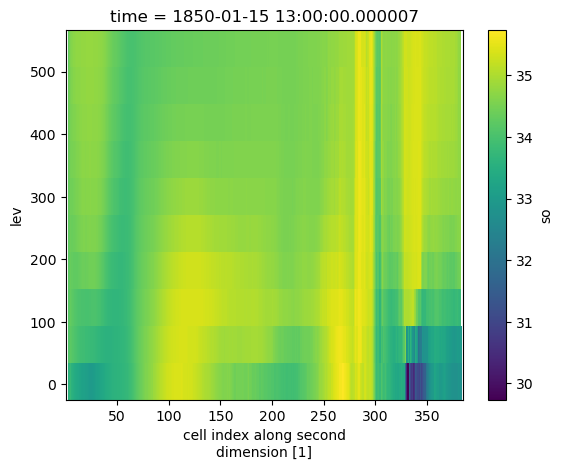

In [4]:
output = ds.regridder.vertical("so", output_grid, tool="xgcm", method="linear")

output.so.isel(time=0).mean(dim="nlon").plot()

### 4. Regridding from depth to density space
Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method.

We'll remap salinity into density space.

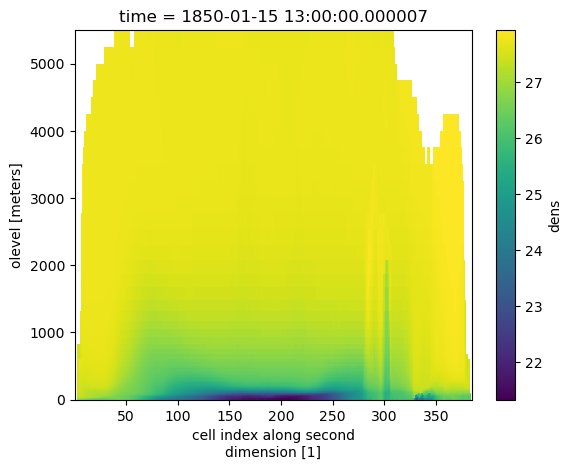

In [5]:
# Apply gsw function to calculate potential density from potential temperature (thetao) and salinity (so)
ds["dens"] = gsw.sigma0(ds.so, ds.thetao)

ds.dens.isel(time=0).mean(dim="nlon").plot()

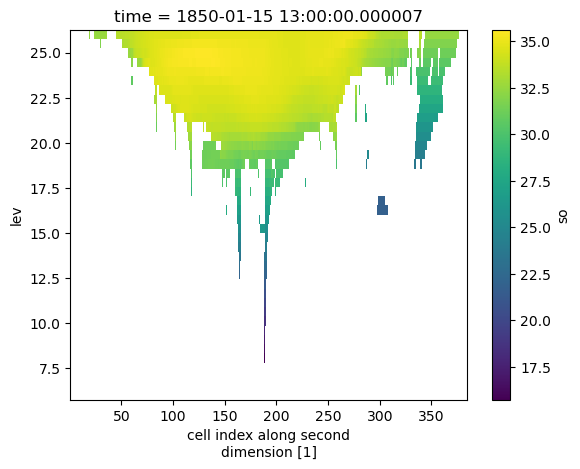

In [6]:
density_grid = xcdat.create_grid(
    z=xcdat.create_axis("lev", np.linspace(6, 26, 40))
)

output = ds.regridder.vertical("so", density_grid, tool="xgcm", method="linear", target_data="dens")

output.so.isel(time=0).mean(dim="nlon").plot()

### 5. Regridding using the `conservative` method
Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `conservative` method.

We"ll transform model levels using conservative regridding. In order to perform the regridding we"ll need two grid positions, the `lev` coordinate is **center** and we"ll create the **outer** points using `cf_xarray`"s `bounds_to_vertices`.

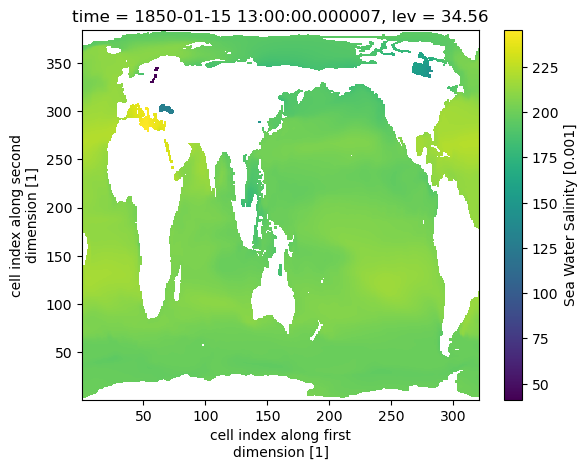

In [7]:
ds_olev = ds.cf.bounds_to_vertices("lev").rename({"lev_vertices": "olev"})

output = ds_olev.regridder.vertical("so", output_grid, tool="xgcm", method="conservative", grid_positions={"center": "lev", "outer": "olev"})

output.so.isel(time=0).sel(lev=0, method="nearest").plot()

## Example 2: Remapping Atmosphere Variables

### 1. Open dataset

In [8]:
# Url of data from the E3SM model in CMIP6
url_ta = 'https://esgf-data2.llnl.gov/thredds/dodsC/user_pub_work/CMIP6/CMIP/E3SM-Project/E3SM-2-0/historical/r1i1p1f1/Amon/ta/gr/v20220830/ta_Amon_E3SM-2-0_historical_r1i1p1f1_gr_185001-189912.nc'
url_cl = 'https://esgf-data2.llnl.gov/thredds/dodsC/user_pub_work/CMIP6/CMIP/E3SM-Project/E3SM-2-0/historical/r1i1p1f1/Amon/cl/gr/v20220830/cl_Amon_E3SM-2-0_historical_r1i1p1f1_gr_185001-189912.nc'

ds_ta = xcdat.open_dataset(url_ta, chunks={"time": 4}, add_bounds=["Z"])
ds_cl = xcdat.open_dataset(url_cl, chunks={"time": 4}) 

### 2. Create the output grid
Related API: [xcdat.create_grid()](../generated/xcdat.create_grid.rst)

In this example, we will generate a grid with a linear spaced level coordinate.

In [9]:
output_grid = xcdat.create_grid(
    z=xcdat.create_axis("lev", np.linspace(100000, 1, 13))
)

output_grid

<xarray.Dataset>
Dimensions:   (lev: 13, bnds: 2)
Coordinates:
  * lev       (lev) float64 1e+05 9.167e+04 8.333e+04 ... 8.334e+03 1.0
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float64 1.042e+05 9.583e+04 ... 4.168e+03 -4.166e+03

### 3. Remapping air temprature on pressure levels to a set of target pressure levels.
Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `log` method. 

We'll remap pressure levels.

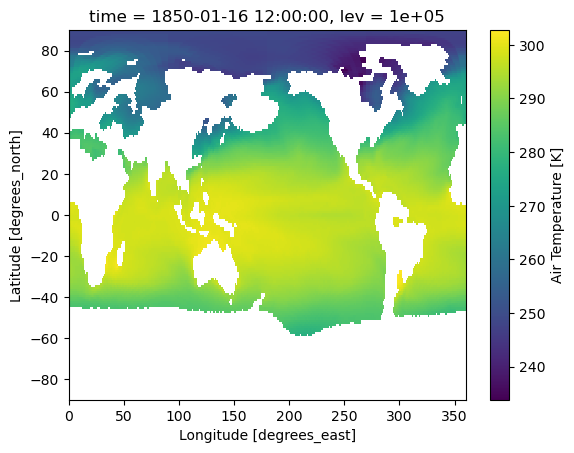

In [10]:
# Remap from original pressure level to target pressure level using logarithmic interpolation 
# Note: output grids can be either acsending or decsending 
output_ta = ds_ta.regridder.vertical("ta", output_grid, method="log")

output_ta.ta.isel(time=0, lev=0).plot()

### 4: Remap cloud fraction from model hybrid coordinate to pressure levels
Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method.

We'll remap salinity into density space.

In [11]:
# Build hybrid pressure coordinate
def hybrid_coordinate(p0, a, b, ps, **kwargs):
    return a*p0 + b*ps

pressure = hybrid_coordinate(**ds_cl.data_vars)

pressure

<xarray.DataArray (lev: 72, time: 600, lat: 180, lon: 360)>
dask.array<add, shape=(72, 600, 180, 360), dtype=float64, chunksize=(72, 4, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.9985 0.9938 0.9862 ... 0.0001828 0.0001238
  * time     (time) object 1850-01-16 12:00:00 ... 1899-12-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

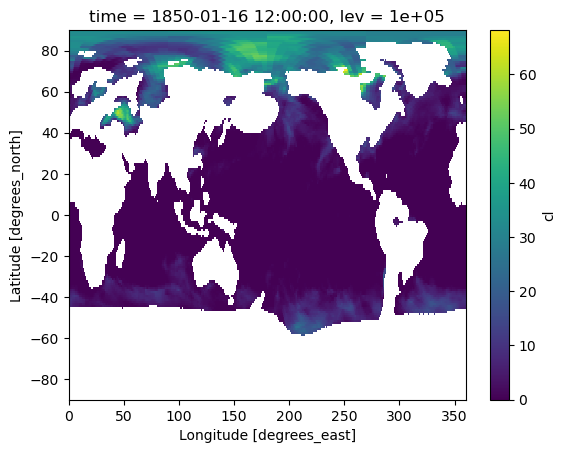

In [12]:
pressure_grid = xcdat.create_grid(
    z=xcdat.create_axis("lev", np.linspace(100000, 1, 13))
)

output_cl = ds_cl.regridder.vertical("cl", pressure_grid, method="linear", target_data=pressure)

output_cl.cl.isel(time=0, lev=0).plot()